In [1]:
# This would ignore some warning that will not affect code
import warnings
warnings.filterwarnings("ignore")
# This would disable some OpenMP lib conflict that cause kernel crash, if environment is stable, it is unnecessary
import os    
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

### Brief Explanation of DQN
DQN combines Q-learning with deep neural networks to train an agent to achieve certain goal in environments with high-dimensional observation spaces. The key ideas for DQN are:

Q-Learning: tells an agent what action to take under certain circumstances by learning the Q-values (Quality of actions). It is an estimation of the total reward an agent can expect to receive by performing a certain action in a given state assuming follow optimal policy thereafter.

Neural Networks: DQN uses neural networks to approximate the Q-value function. The network input is the state of the environment and output is a Q-value for each possible action.

Experience Replay: DQN use a replay buffer to store the agent's experiences at each time step. Random batches from this buffer are used to train the network, which helps in stabilizing and improving the learning process.

Fixed Q-Targets: To further stabilize training, DQN uses a separate target network to compute the target Q-values that we compare our predicted Q-values against. This network's weights are updated less frequently to keep the target function stable.


### Preconditions:
We use Pytorch lib for neural network, before running following code, it is necessary to install torch first

Google colab embeded torch

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import random
from collections import deque
import gym

### DQN Network

Defines a neural network with three fully connected layers.

Takes the environment state as input and outputs Q-values for all possible actions.

The forward method defines how data moves through the network, using ReLU activations between layers.

In [3]:
class DQN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, output_dim)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)


### Replay Buffer

Implements a replay buffer using a deque (a double-ended queue) with a fixed maximum length (capacity).

push method adds experience tuples (state, action, reward, next_state, done) to the buffer.

sample method randomly retrieves a batch of experiences for training.

This buffer helps in breaking correlation between consecutive learning samples and stabilizes learning.

In [4]:
class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)

    def push(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        state, action, reward, next_state, done = zip(*random.sample(self.buffer, batch_size))
        return np.array(state), np.array(action), np.array(reward, dtype=np.float32), np.array(next_state), np.array(done, dtype=np.uint8)

    def __len__(self):
        return len(self.buffer)


# Following is training process, If you wish to load pre-trained model, you do not need to run it

### Computing TD Loss

This function calculates the temporal difference (TD) loss for a batch of experiences.

It involves computing the predicted Q-values and the target Q-values, then using the mean squared error (MSE) loss between them.

optimizer.zero_grad() clears old gradients

loss.backward() computes gradient of loss w.r.t all weights

optimizer.step() updates the weights.

This function uses the concept of fixed Q-targets to stabilize training 

In [5]:
def compute_td_loss(batch_size, replay_buffer, model, optimizer, gamma=0.99):
    state, action, reward, next_state, done = replay_buffer.sample(batch_size)
    state = torch.FloatTensor(state)
    next_state = torch.FloatTensor(next_state)
    action = torch.LongTensor(action)
    reward = torch.FloatTensor(reward)
    done = torch.FloatTensor(done)

    q_values = model(state).gather(1, action.unsqueeze(1)).squeeze(1)
    next_q_values = model(next_state).max(1)[0]
    expected_q_values = reward + gamma * next_q_values * (1 - done)

    loss = F.mse_loss(q_values, expected_q_values.detach())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    return loss

### Main training

This is the main training logic of DQN

In each training episode:

1. Reset cartpole environment

2. Loop following until failed or reach maximum:

    2.1 Epsilon parameter change according to total steps already taken
    
    2.2 Choose to choose a random action or used existing experience according to epsilon parameter
    
    2.3 Store this state, action, reward, next state into replay buffer
        
      2.3.1 If the replay buffer has enough experiences (more than batch_size), sample a batch and compute the loss using the compute_td_loss function. Perform a gradient descent step to update the model weights based on the computed loss.
    
    2.4 Step to next state
    
Important parameters:

episode: Determines how many times to loop

eps_start, eps_end, eps_decay: control random action rate and its decrease rate, higher eps_decay -> slower decrease rate

batch_size: The size of the sample from the replay buffer used for training the model in each step.

gamma: The discount factor used to compute the future discounted reward. It balances the importance of immediate versus future rewards.

In [11]:
def train_dqn(env,episode, model, optimizer, replay_buffer, eps_start=0.9, eps_end=0.05, eps_decay=1000, batch_size=128, gamma=0.99):
    episode_rewards = []
    steps_done = 0
    for ep in range(episode):
        state = env.reset()
        total_reward = 0
        while True:
            eps_threshold = eps_end + (eps_start - eps_end) * np.exp(-1. * steps_done / eps_decay)
            steps_done += 1
            if random.random() < eps_threshold:
                action = env.action_space.sample()
            else:
                with torch.no_grad():
                    state_tensor = torch.FloatTensor(state).unsqueeze(0)
                    action = model(state_tensor).max(1)[1].item()
            next_state, reward, done, _ = env.step(action)
            replay_buffer.push(state, action, reward, next_state, done)
            if len(replay_buffer) > batch_size:
                compute_td_loss(batch_size, replay_buffer, model, optimizer, gamma)
            state = next_state
            total_reward += reward
            if done:
                break
        print(f"Episode: {ep}, Total Reward: {total_reward}")
        episode_rewards.append(total_reward)
        
    return episode_rewards

Following code run previous functions to train a model and display training process

In [16]:
env = gym.make("CartPole-v1")
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n
    
model = DQN(state_dim, action_dim)
optimizer = optim.Adam(model.parameters())
replay_buffer = ReplayBuffer(10000)

episode_rewards=train_dqn(env=env,episode=500, model=model, optimizer=optimizer, replay_buffer=replay_buffer)

Episode: 0, Total Reward: 15.0
Episode: 1, Total Reward: 34.0
Episode: 2, Total Reward: 14.0
Episode: 3, Total Reward: 13.0
Episode: 4, Total Reward: 13.0
Episode: 5, Total Reward: 38.0
Episode: 6, Total Reward: 18.0
Episode: 7, Total Reward: 19.0
Episode: 8, Total Reward: 11.0
Episode: 9, Total Reward: 10.0
Episode: 10, Total Reward: 17.0
Episode: 11, Total Reward: 22.0
Episode: 12, Total Reward: 15.0
Episode: 13, Total Reward: 26.0
Episode: 14, Total Reward: 14.0
Episode: 15, Total Reward: 13.0
Episode: 16, Total Reward: 14.0
Episode: 17, Total Reward: 19.0
Episode: 18, Total Reward: 26.0
Episode: 19, Total Reward: 24.0
Episode: 20, Total Reward: 14.0
Episode: 21, Total Reward: 27.0
Episode: 22, Total Reward: 16.0
Episode: 23, Total Reward: 62.0
Episode: 24, Total Reward: 63.0
Episode: 25, Total Reward: 47.0
Episode: 26, Total Reward: 27.0
Episode: 27, Total Reward: 56.0
Episode: 28, Total Reward: 64.0
Episode: 29, Total Reward: 25.0
Episode: 30, Total Reward: 78.0
Episode: 31, Total

Episode: 249, Total Reward: 500.0
Episode: 250, Total Reward: 500.0
Episode: 251, Total Reward: 330.0
Episode: 252, Total Reward: 472.0
Episode: 253, Total Reward: 415.0
Episode: 254, Total Reward: 500.0
Episode: 255, Total Reward: 500.0
Episode: 256, Total Reward: 500.0
Episode: 257, Total Reward: 500.0
Episode: 258, Total Reward: 500.0
Episode: 259, Total Reward: 500.0
Episode: 260, Total Reward: 120.0
Episode: 261, Total Reward: 500.0
Episode: 262, Total Reward: 129.0
Episode: 263, Total Reward: 117.0
Episode: 264, Total Reward: 500.0
Episode: 265, Total Reward: 117.0
Episode: 266, Total Reward: 500.0
Episode: 267, Total Reward: 264.0
Episode: 268, Total Reward: 172.0
Episode: 269, Total Reward: 190.0
Episode: 270, Total Reward: 500.0
Episode: 271, Total Reward: 500.0
Episode: 272, Total Reward: 49.0
Episode: 273, Total Reward: 396.0
Episode: 274, Total Reward: 500.0
Episode: 275, Total Reward: 31.0
Episode: 276, Total Reward: 25.0
Episode: 277, Total Reward: 46.0
Episode: 278, Tota

Episode: 492, Total Reward: 402.0
Episode: 493, Total Reward: 30.0
Episode: 494, Total Reward: 153.0
Episode: 495, Total Reward: 213.0
Episode: 496, Total Reward: 165.0
Episode: 497, Total Reward: 500.0
Episode: 498, Total Reward: 500.0
Episode: 499, Total Reward: 500.0


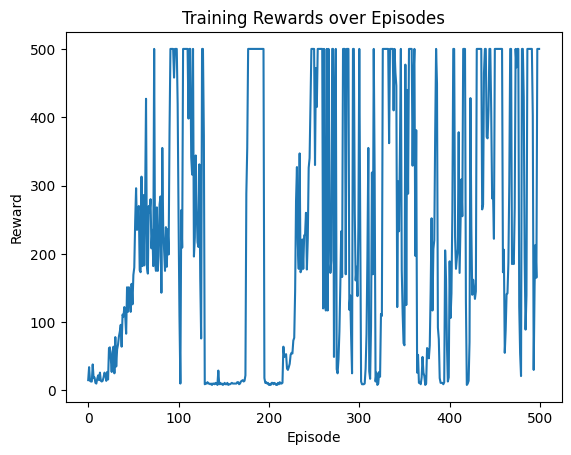

In [17]:
import os    
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

import matplotlib.pyplot as plt
plt.plot(episode_rewards)
plt.title("Training Rewards over Episodes")
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.show()


In [20]:
# If you run this code block, pre-trained model would be replaced
# torch.save(model.state_dict(), 'model_weights.pth')
# env.close()

# If you wish to use pre-trained model, start form here

This code load trained model

In [21]:
env = gym.make("CartPole-v1")
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n

model = DQN(state_dim, action_dim)
model.load_state_dict(torch.load('model_weights.pth'))
model.eval()

C:\Users\GuShucheng\anaconda3\Lib\site-packages\gym\core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
C:\Users\GuShucheng\anaconda3\Lib\site-packages\gym\wrappers\step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


DQN(
  (fc1): Linear(in_features=4, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=2, bias=True)
)

#### get_action 

return an action according to model

always choose the action with maximum q-value (expected gain)

In [22]:
def get_action(observation, model):
    observation_tensor = torch.FloatTensor(observation).unsqueeze(0)
    with torch.no_grad():
        q_values = model(observation_tensor)
        action = q_values.max(1)[1].item()
    return action

C:\Users\GuShucheng\anaconda3\Lib\site-packages\gym\utils\passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


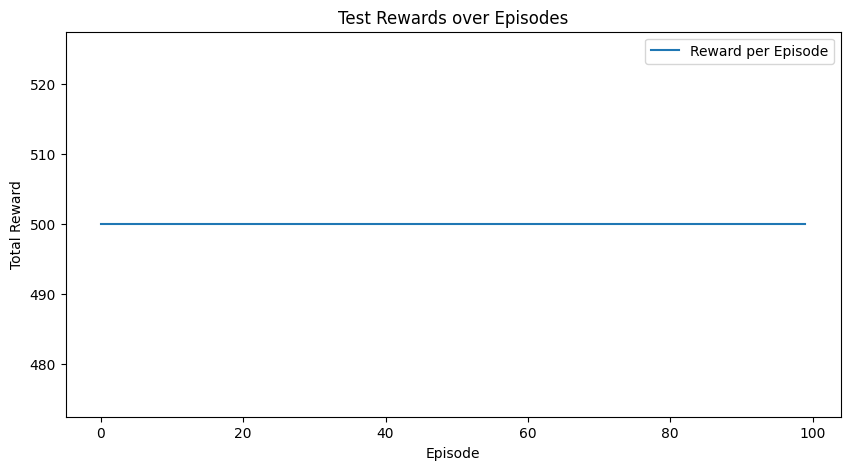

Average Reward: 500.0


In [23]:
def test_dqn(env,model, episode=10):
    episode_rewards = []
    for ep in range(episode):
        state = env.reset()
        total_reward = 0
        while True:
            action = get_action(state, model)
            next_state, reward, done, _ = env.step(action)
            total_reward += reward
            state = next_state
            if done:
                break
        episode_rewards.append(total_reward)
    
    plt.figure(figsize=(10, 5))
    plt.plot(episode_rewards, label='Reward per Episode')
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')
    plt.title('Test Rewards over Episodes')
    plt.legend()
    plt.show()
    average_reward = sum(episode_rewards) / len(episode_rewards)
    print(f"Average Reward: {average_reward}")

    
test_dqn(env,model, 100)